In [22]:
## This jupyter notebook need to be run in main folder
import numpy as np
import pandas as pd
from src.concat_image import *
from src.metrics_acc_iou import *
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 
%matplotlib inline
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}

plt.rc('font', **font)

In [2]:
mit = pd.read_csv("logs/mit_vs_psp_acc_iou_annotation.csv")

In [4]:
# label_info = np.zeros((len(mit), 153))  ## Columns: Width, Height, labels 0 ~ 150 
# labels = ["lab_" + str(i) for i in range(0, 151)]
# label_columns = ["width", "height"]
# label_columns.extend(labels)
# for i in range(len(mit)):
#     annot_path = mit["val_img"][i]
#     annot_path = "data/ADEChallengeData2016/annotations/" + annot_path[:-4] + ".png"
#     annot_img = imread(annot_path)
#     w, h = annot_img.shape
#     label_info[i, 0] = w
#     label_info[i, 1] = h
#     img_label_list = np.unique(annot_img)
#     for img_label in img_label_list:
#         label_info[i, img_label + 2] = np.sum(annot_img == img_label)/float(w * h)
# label_df = pd.DataFrame(label_info, columns=label_columns)
# mit = pd.concat([mit, label_df], axis=1)

In [3]:
mit.head(2)

,Unnamed: 0,val_img,acc,iou,psp50_acc,psp50_iou,scene,width,height,lab_0,...,lab_141,lab_142,lab_143,lab_144,lab_145,lab_146,lab_147,lab_148,lab_149,lab_150
0,0,validation/ADE_val_00000001.jpg,0.632343,0.620235,0.952150,0.770030,abbey,512.0,683.0,0.010332,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,validation/ADE_val_00000002.jpg,0.917770,0.521776,0.878315,0.393003,abbey,364.0,500.0,0.094945,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
acc = mit.groupby(["scene"]).mean()["acc"]
count = mit.groupby(["scene"]).count()["acc"]
var = mit.groupby(["scene"]).var()["acc"]
scene_df = pd.concat([acc,count,var], axis = 1)
scene_df.columns = ["mean acc", "count", "var acc"]
scene_df = scene_df.sort_values("mean acc")
scene_df.to_csv("scene_acc.csv")

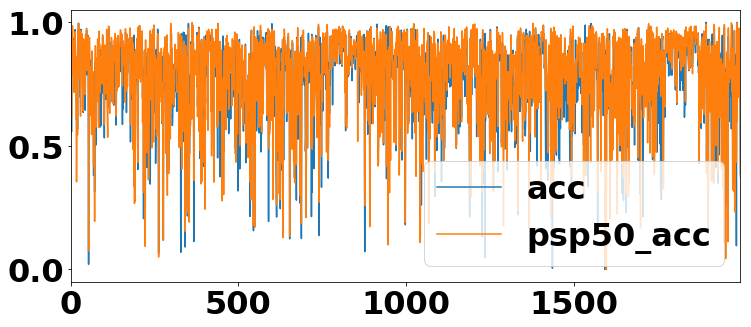

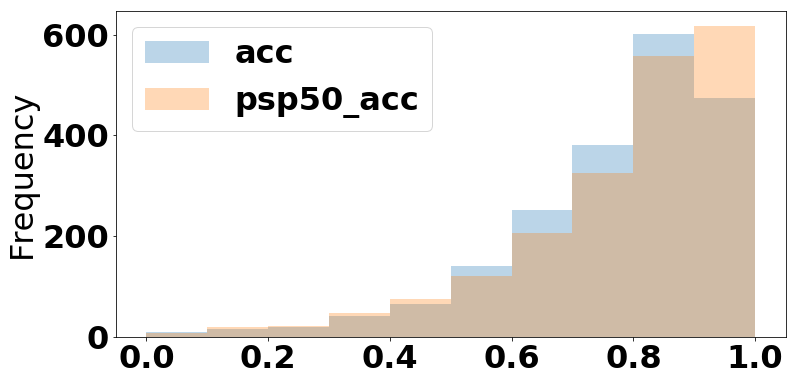

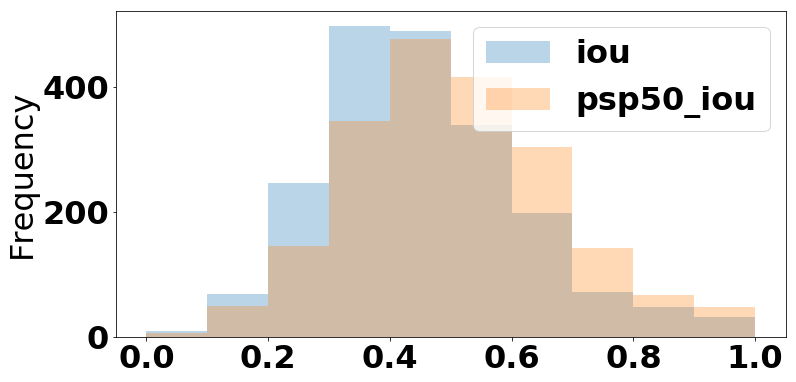

In [7]:
mit.plot(x = mit.index, y = ["acc", "psp50_acc"], figsize=(12,5))
mit[["acc", "psp50_acc"]].plot(kind="hist", alpha = 0.3, figsize = (12,6))
mit[["iou", "psp50_iou"]].plot(kind="hist", alpha = 0.3, figsize = (12,6))

In [39]:
colors = loadmat("data/color150.mat")['colors'] ## Load colormap
image_folder = "data/ADEChallengeData2016/images/validation/"
annot_folder = "data/ADEChallengeData2016/annotations/validation/"
pred_list_psp = [x.rstrip() for x in open("results/pspnet50/val_list", 'r')]
pred_list_mit = [x.rstrip() for x in 
                open("results/baseline-resnet34_dilated8-psp_bilinear/val_list.txt", 
                         'r')]
obj_df = pd.read_csv("data/object150_info.csv")
def colorlabel(color_list, index):
    obj_list = obj_df[obj_df["Idx"].isin(color_list+1)]["Name"].values
    n_obj = len(obj_list)
    img_list = ["color150/" + obj.split(";")[0] + ".jpg" for obj in obj_list]
    images = map(Image.open, img_list)
    widths, heights = zip(*(i.size for i in images))
    total_height = sum(heights)
    width_max = max(widths)
    new_im = Image.new('RGB', (width_max , total_height))
    y_offset = 0
    for im in images:
      new_im.paste(im, (0, y_offset))
      y_offset += im.size[1]
    new_im.show()
    plt.imshow(np.asarray(new_im))
    plt.axis('off')
    plt.savefig("color" + str(index) + ".jpg", bbox_inches='tight')
def check_img(index, model):
    if model == "pspnet50":
        pred_path = pred_list_psp[index]
    else:
        pred_path = pred_list_mit[index]
    pred_pic = np.load(pred_path) - 1
    picname = pred_path.split("/")[-1][:-4]
    raw_path = image_folder + picname + ".jpg"
    val_path = annot_folder + picname + ".png"
    raw_pic = imread(raw_path)
    val_pic = imread(val_path).astype("int16") - 1
    img_comb_ = ConcatenateImg(raw_pic, val_pic, pred_pic, colors)
    plt.imshow(img_comb_)
    plt.axis('off')
    plt.savefig(model + str(index) + ".jpg", bbox_inches='tight')
    pred_color = np.unique(pred_pic)
    val_color = np.unique(val_pic)
    color_list = np.unique(np.union1d(pred_color, val_color))
    color_list = color_list[color_list > 0]
    return color_list

def visualize_singleimg(index):
    fig = plt.figure(figsize=(20,10))
    color_list_psp = check_img(index, "pspnet50")
    plt.title("pspnet50")
    plt.show()
    fig = plt.figure(figsize=(20,10))
    color_list_mit = check_img(index, "mit")
    plt.title("MIT")
    plt.show()
    color_list = np.unique(np.union1d(color_list_psp, color_list_mit))
    colorlabel(color_list, index)
    
# def pred_img(index, model):
#     if model == "pspnet50":
#         pred_path = pred_list_psp[index]
#     else:
#         pred_path = pred_list_mit[index]
#     pred_pic = np.load(pred_path) - 1
#     picname = pred_path.split("/")[-1][:-4]
#     raw_path = image_folder + picname + ".jpg"
#     val_path = annot_folder + picname + ".png"
#     raw_pic = imread(raw_path)
#     val_pic = imread(val_path).astype("int16") - 1
#     img_comb_ = ConcatenateImg(raw_pic, pred_pic, colors)
#     plt.imshow(img_comb_)
#     pred_color = np.unique(pred_pic)
#     val_color = np.unique(val_pic)
#     color_list = np.unique(pred_color)
#     color_list = color_list[color_list > 0]
#     return color_list
# def demo_img(index):
#     fig = plt.figure(figsize=(10,20))
#     color_list_psp = pred_img(index, "pspnet50")
#     plt.title("pspnet50")
#     plt.show()
#     color_list = np.unique(color_list_psp)
#     colorlabel(color_list)

In [10]:
mit.sort_values("acc", ascending=False)

,Unnamed: 0,val_img,acc,iou,psp50_acc,psp50_iou,scene,width,height,lab_0,...,lab_141,lab_142,lab_143,lab_144,lab_145,lab_146,lab_147,lab_148,lab_149,lab_150
1987,1987,validation/ADE_val_00001989.jpg,1.000000,1.000000,0.997281,0.998304,sand_trap,423.0,800.0,0.498942,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1895,1895,validation/ADE_val_00001897.jpg,1.000000,1.000000,0.993294,0.993294,ocean_deep,256.0,256.0,0.062576,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
23,23,validation/ADE_val_00000024.jpg,0.996511,0.983562,0.996085,0.981520,apartment_building_outdoor,512.0,683.0,0.006649,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1552,1552,validation/ADE_val_00001554.jpg,0.995482,0.990267,0.971789,0.969492,mountain,256.0,256.0,0.074554,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
351,351,validation/ADE_val_00000352.jpg,0.995247,0.988375,0.974407,0.975786,firing_range_indoor,512.0,683.0,0.008464,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
439,439,validation/ADE_val_00000440.jpg,0.994880,0.973882,0.994317,0.971364,ice_skating_rink_outdoor,385.0,580.0,0.554765,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
600,600,validation/ADE_val_00000601.jpg,0.994347,0.985343,0.970604,0.941394,misc,429.0,700.0,0.643054,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
914,914,validation/ADE_val_00000915.jpg,0.992848,0.947569,0.974318,0.919066,water_tower,375.0,500.0,0.114901,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1024,1024,validation/ADE_val_00001025.jpg,0.992072,0.981816,0.981257,0.973733,aquatic_theater,512.0,683.0,0.010575,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1972,1972,validation/ADE_val_00001974.jpg,0.990389,0.967674,0.990885,0.983241,mountain_snowy,256.0,256.0,0.015625,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000


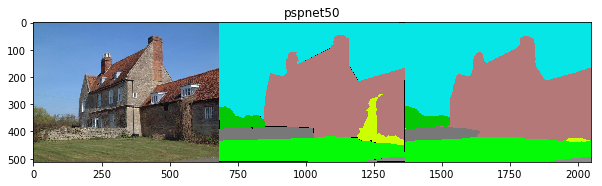

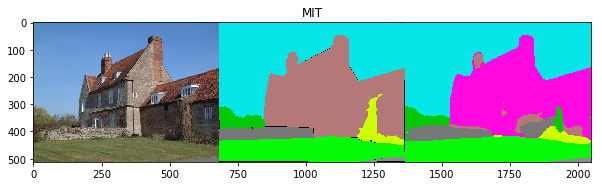

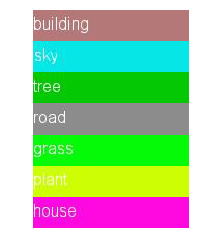

In [188]:
visualize_singleimg(0)  ## Confusion house and building

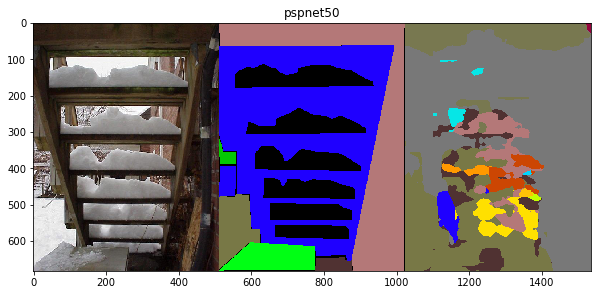

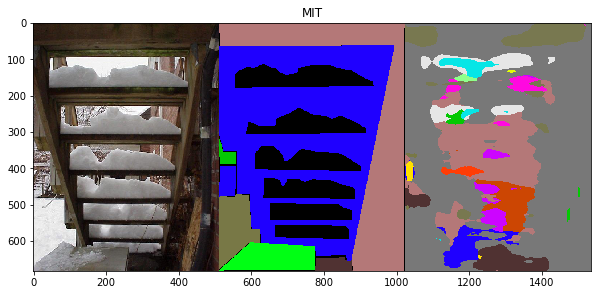

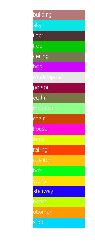

In [183]:
visualize_singleimg(53) ## Challengenging staircase 

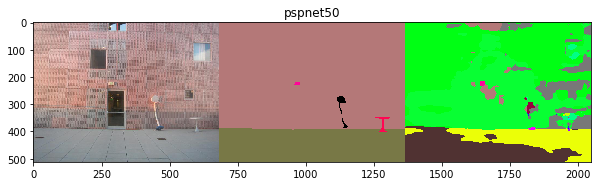

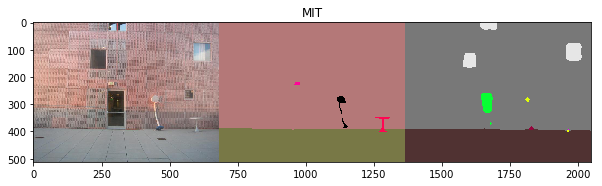

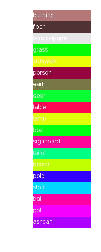

In [186]:
visualize_singleimg(1594) ## Confusion annotation, and insufficient MIT has good door and window, but not annotated. Low accuracy

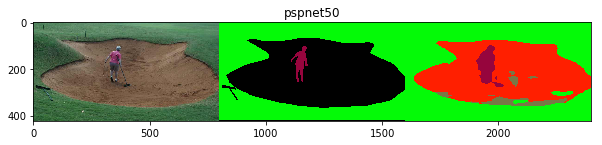

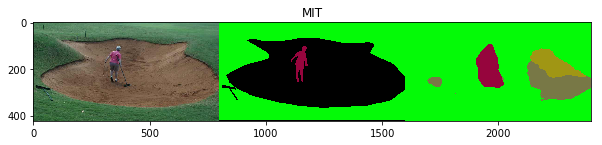

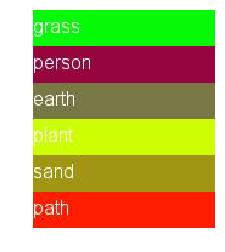

In [189]:
visualize_singleimg(1987) ## Simple case, high accuracy

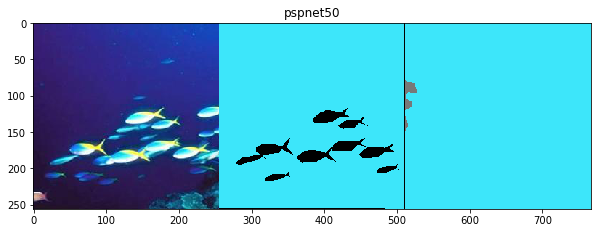

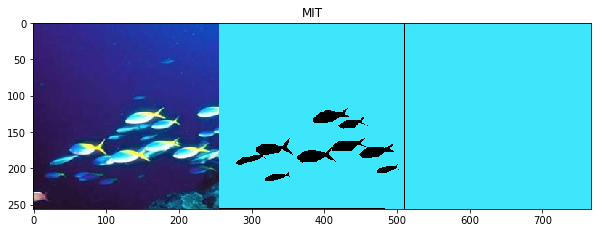

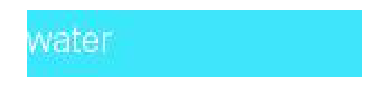

In [190]:
visualize_singleimg(1895) ## Simple water high accuracy

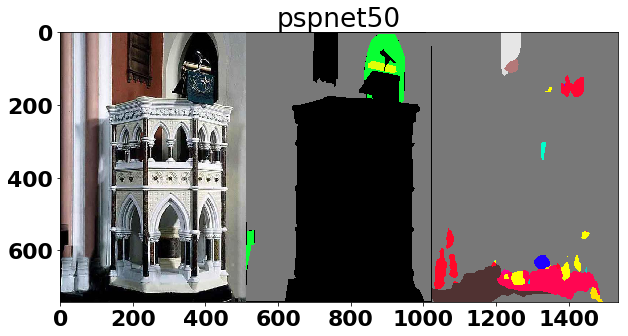

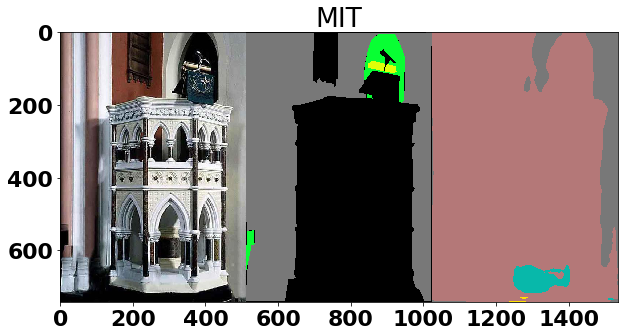

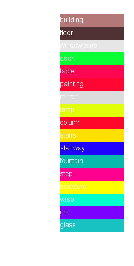

In [215]:
visualize_singleimg(718)  ## In sufficient annotation

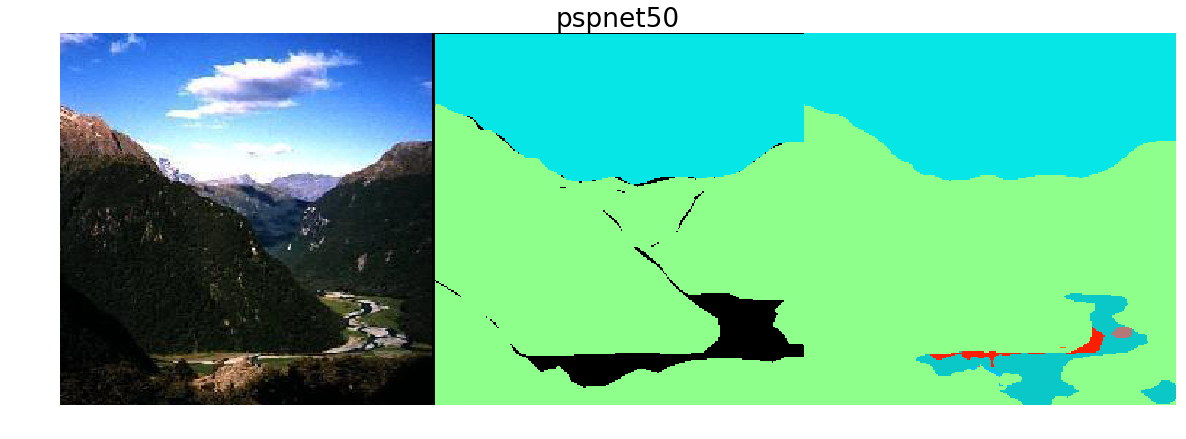

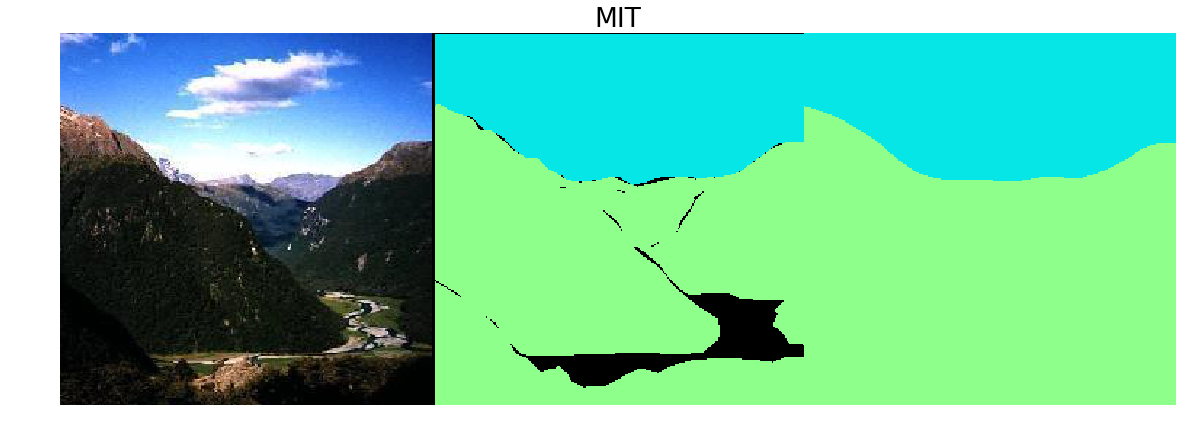

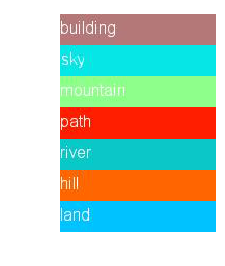

In [40]:
visualize_singleimg(1552)

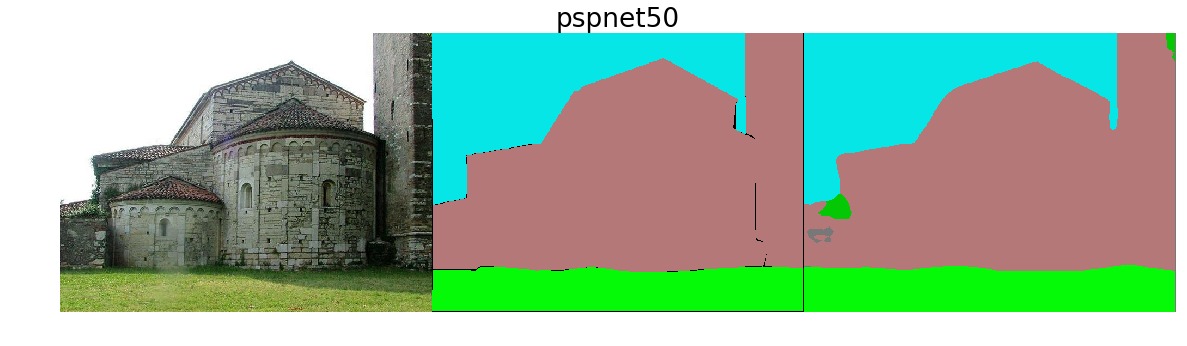

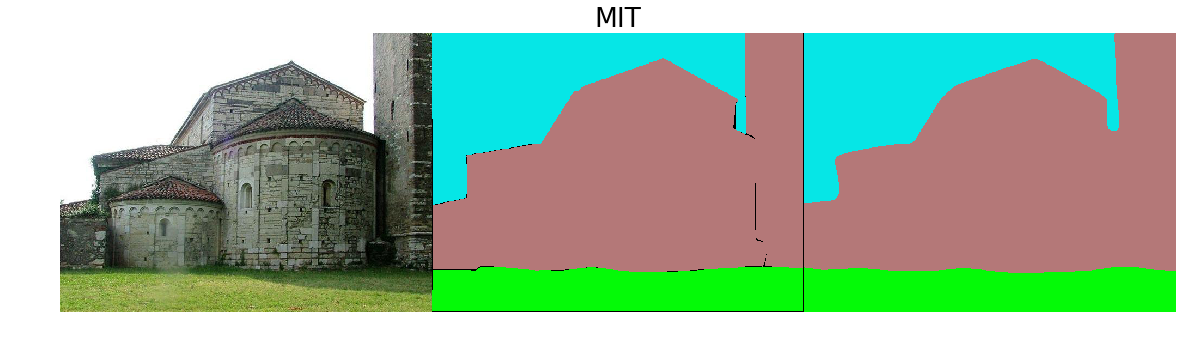

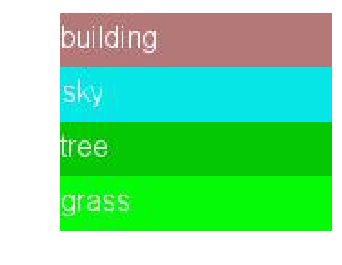

In [31]:
visualize_singleimg(1024)

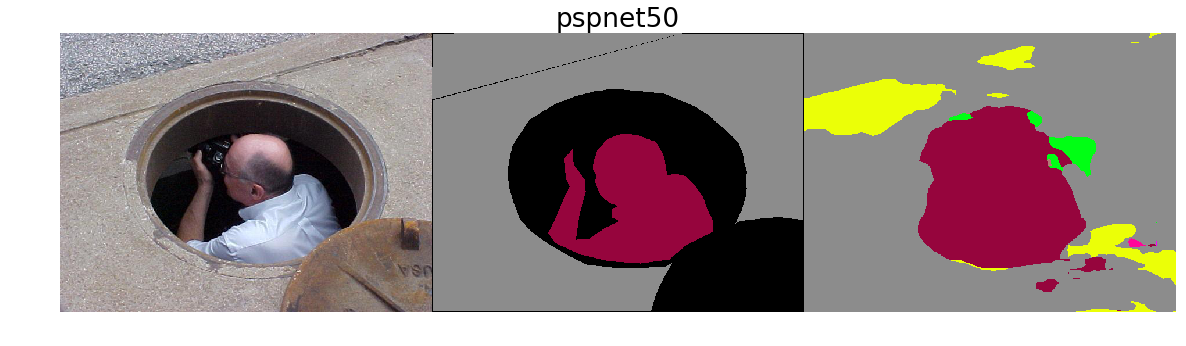

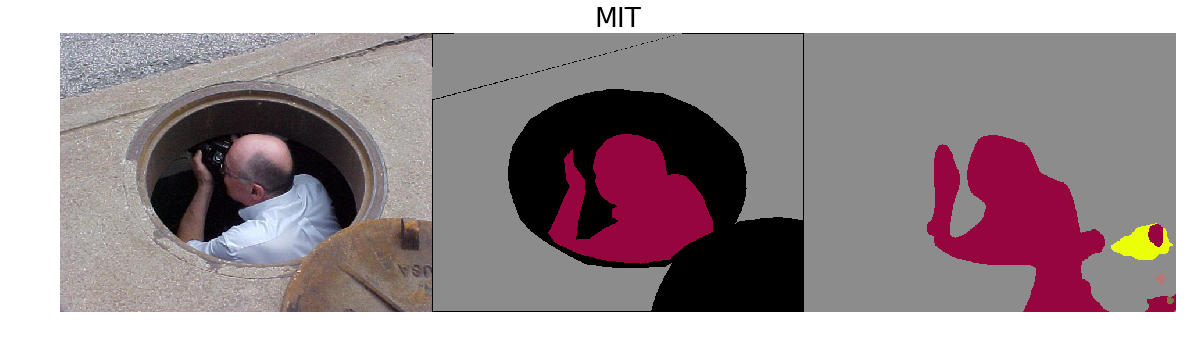

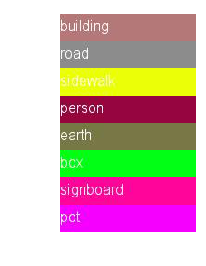

In [32]:
visualize_singleimg(1535)

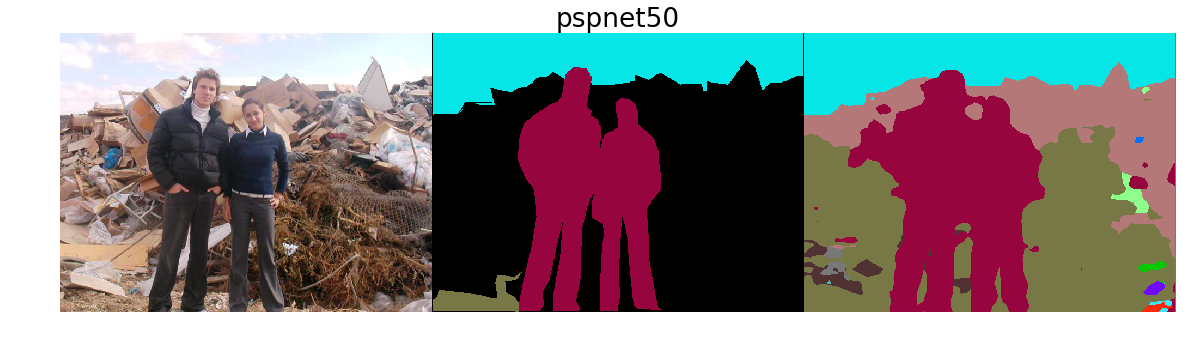

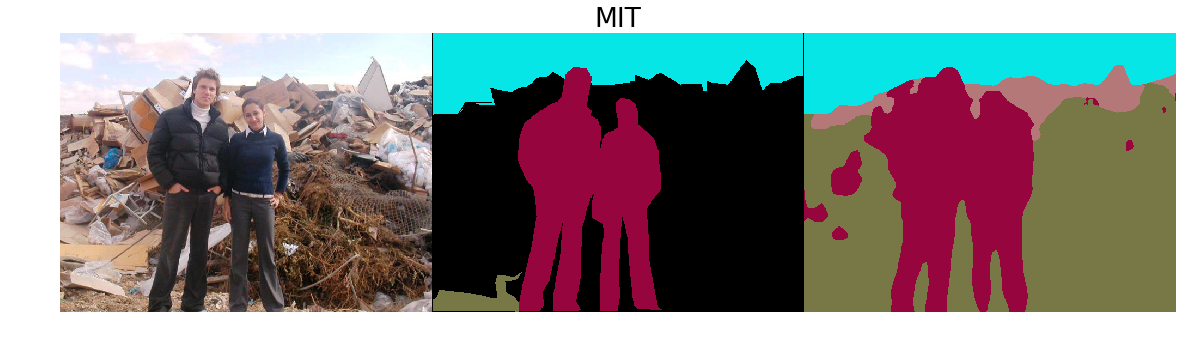

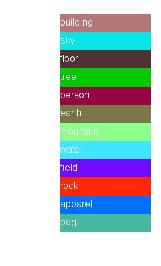

In [33]:
visualize_singleimg(1379)